This implementation is based on paper "https://arxiv.org/abs/1609.02907". We have tried to reimplement the experiment using pytorch refererring the orginal code from "https://github.com/tkipf/gcn" which is orginally written in tensorflow. We are also inspired from few resources which uses GCN as industry standard libraries such as torch_geometeric and dgl. 

# Install Libraries

In [1]:
# !pip install torch_geometric
# !pip install dgl==1
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [39]:
import time
import numpy as np
import scipy.sparse as sp
import networkx as nx
import pickle as pkl
import math
from scipy.sparse.linalg import eigsh
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from random import randrange

# Data Loading and Preprocessing 

In [40]:
# normalize sparse adj matrix and features
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    row_inv = np.power(rowsum, -1).flatten()
    row_inv[np.isinf(row_inv)] = 0.
    row_mat_inv = sp.diags(row_inv)
    mx = row_mat_inv.dot(mx)
    return mx
# Convert a scipy sparse matrix to a torch sparse tensor.
def sparse_matrix_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

# calulate accuracy from predicted labels and groundtruth
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# Parse index file
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index
    
# load data for citseer, cora and pubmed with file extensions x,y,tx,ty,allx,ally,graph
def load_data(dataset_str):
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # normalize features and adjmatrix
    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    # explicitly stated  train, val and test splits
  
    if dataset_str == 'citeseer':
        idx_train = range(120)
    elif dataset_str == 'cora':
        idx_train = range(140)
    elif dataset_str == 'pubmed':
        idx_train = range(60)
    else:
      idx_train = range(100)
    idx_val = range(200, 700)
    idx_test = range(700, 1700)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_matrix_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    return adj, features, labels, idx_train, idx_val, idx_test

def random_split(num_total, num_train, num_val, num_test, shuffle=True):
    # Create a list of indices for the given range
    indices = list(range(num_total))
    # Shuffle the indices randomly if shuffle=True
    if shuffle:
        np.random.shuffle(indices)
    # Split the shuffled indices into train, validation, and test sets
    idx_train = indices[:num_train]
    idx_val = indices[num_train:num_train+num_val]
    idx_test = indices[num_train+num_val:num_train+num_val+num_test]
    return idx_train, idx_val, idx_test

# GCN Model

In [41]:
class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN(nn.Module):
    def __init__(self, nfeatures, nhidden_layers, nclass, dropout, batch_normalization=False):
        super(GCN, self).__init__()

        if batch_normalization:
          self.gc1 = GraphConvolution(nfeatures, nhidden_layers)
          self.bn1 = nn.BatchNorm1d(nhidden_layers)
          self.gc2 = GraphConvolution(nhidden_layers, nclass)
          self.bn2 = nn.BatchNorm1d(nclass)
          self.dropout = dropout
        else:
          self.gc1 = GraphConvolution(nfeatures, nhidden_layers)
          self.gc2 = GraphConvolution(nhidden_layers, nclass)
          self.dropout = dropout


    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

# Model Training 

### Train and Test

In [42]:
# train the GCN model, default is single run with 200 epochs
def train_model(epoch, type='single_train'):
    start = time.time()
    model.train()
    optimizer.zero_grad()
    out_features = model(features, adj)
    loss_train = F.nll_loss(out_features[idx_train], labels[idx_train])
    acc_train = accuracy(out_features[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    # Evaluate validation set performance separately,
    # deactivates dropout during validation run.
    model.eval()
    out_features = model(features, adj)

    loss_val = F.nll_loss(out_features[idx_val], labels[idx_val])
    acc_val = accuracy(out_features[idx_val], labels[idx_val])
    print('Epoch: {:03d}'.format(epoch),
        'loss_train: {:.3f}'.format(loss_train.item()),
        'acc_train: {:.3f}'.format(acc_train.item()),
        'loss_val: {:.3f}'.format(loss_val.item()),
        'acc_val: {:.3f}'.format(acc_val.item()),
        'time: {:.3f}s'.format(time.time() - start))
    
    if type == 'single_train':
      return  acc_val, loss_val, out_features
    else:
      return acc_val, loss_val

 # test the GCN model     
def test_model():
    model.eval()
    out_features = model(features, adj)
    loss_test = F.nll_loss(out_features[idx_test], labels[idx_test])
    acc_test = accuracy(out_features[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.3f}".format(loss_test.item()),
          "accuracy= {:.3f}".format(acc_test.item()))
    return acc_test, loss_test

### Parameters and Model Initialization
Any parameters change should be done here including selecting dataset from citseer, cora and pubmed.

In [43]:
## hyperparameters initialization
seed = 42
hidden = 16
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
epochs = 200


# chocie of GPU using cuda or cpu
cuda = torch.cuda.is_available()
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
  torch.cuda.manual_seed(seed)

# load datasets
#dataset = 'citeseer'
dataset = 'cora'
#dataset = 'pubmed'
adj, features, labels, idx_train, idx_val, idx_test = load_data(dataset)

# model and optimizer
model = GCN(nfeatures=features.shape[1],
            nhidden_layers=hidden,
            nclass=labels.max().item() + 1,
            dropout= dropout)
optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)

# add initialized model and data to cuda
if cuda:
  model.cuda()
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()
  idx_train = idx_train.cuda()
  idx_val = idx_val.cuda()
  idx_test = idx_test.cuda()

<ipython-input-40-7206d1f64c60>:38: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  objects.append(pkl.load(f, encoding='latin1'))


### Single Run Experiment
This is generic experiment run once which will further train model for 200 epochs as initialized in the hyperparameters initialization and calculate validation accuracy and loss.

###1. Without EarlyStopping and BatchNormalization

In [ ]:
# runs the training for single run
def single_run1(earlyStopping=False):
  # Training the model
  start = time.time()
  val_acc_list = []
  val_loss_list = []
  for epoch in range(epochs):
      val_acc, loss_val, out_features = train_model(epoch, type='single_train')
      val_acc_list.append(val_acc.item())
      val_loss_list.append(loss_val.item())
  print("Model Optimization Completed!")
  print("Total time elapsed: {:.3f}s".format(time.time() - start))

  # Test the model
  test_model()
  return val_acc_list, val_loss_list, out_features
  
# single run output: val acc, val loos, outfeatures
val_acc_list, val_loss_list, out_features = single_run1()

####2. With EarlyStopping

In [46]:
def single_run2(patience=10, earlyStopping=True):
  # Training the model
  start = time.time()
  val_acc_list = []
  val_loss_list = []
  best_val_acc = 0
  counter = 0

  for epoch in range(epochs):
      val_acc, loss_val, out_features = train_model(epoch, type='single_train')
      val_acc_list.append(val_acc.item())
      val_loss_list.append(loss_val.item())

      # Check if validation accuracy has improved, and if not, increment the counter
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          counter = 0
      else:
          counter += 1

      # If the counter reaches the patience value, stop training and print message
      if counter == patience:
          print(f'Early stopping after {epoch+1} epochs with no improvement in validation accuracy.')
          break

  print("Model Optimization Completed!")
  print("Total time elapsed: {:.3f}s".format(time.time() - start))

  # Test the model
  test_model()
  return val_acc_list, val_loss_list, out_features

# single run output: val acc, val loos, outfeatures
val_acc_list, val_loss_list, out_features = single_run2()

Epoch: 000 loss_train: 0.308 acc_train: 0.979 loss_val: 0.754 acc_val: 0.792 time: 0.015s
Epoch: 001 loss_train: 0.285 acc_train: 0.993 loss_val: 0.754 acc_val: 0.790 time: 0.007s
Epoch: 002 loss_train: 0.323 acc_train: 0.950 loss_val: 0.749 acc_val: 0.794 time: 0.007s
Epoch: 003 loss_train: 0.277 acc_train: 0.971 loss_val: 0.743 acc_val: 0.792 time: 0.007s
Epoch: 004 loss_train: 0.294 acc_train: 0.986 loss_val: 0.741 acc_val: 0.790 time: 0.005s
Epoch: 005 loss_train: 0.329 acc_train: 0.964 loss_val: 0.741 acc_val: 0.794 time: 0.006s
Epoch: 006 loss_train: 0.346 acc_train: 0.943 loss_val: 0.741 acc_val: 0.796 time: 0.006s
Epoch: 007 loss_train: 0.297 acc_train: 0.971 loss_val: 0.738 acc_val: 0.794 time: 0.006s
Epoch: 008 loss_train: 0.328 acc_train: 0.943 loss_val: 0.737 acc_val: 0.790 time: 0.006s
Epoch: 009 loss_train: 0.255 acc_train: 0.993 loss_val: 0.736 acc_val: 0.792 time: 0.005s
Epoch: 010 loss_train: 0.301 acc_train: 0.979 loss_val: 0.734 acc_val: 0.794 time: 0.005s
Epoch: 011

####3. With batch normalization

In [ ]:
# runs the training for single run
def single_run3(earlyStopping=False):
  # Training the model
  start = time.time()
  val_acc_list = []
  val_loss_list = []
  for epoch in range(epochs):
      val_acc, loss_val, out_features = train_model(epoch, type='single_train')
      val_acc_list.append(val_acc.item())
      val_loss_list.append(loss_val.item())
  print("Model Optimization Completed!")
  print("Total time elapsed: {:.3f}s".format(time.time() - start))

  # Test the model
  test_model()
  return val_acc_list, val_loss_list, out_features
  
# model and optimizer
model = GCN(nfeatures=features.shape[1],
            nhidden_layers=hidden,
            nclass=labels.max().item() + 1,
            dropout= dropout, batch_normalization=True)
optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)

# add initialized model and data to cuda
if cuda:
  model.cuda()
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()
  idx_train = idx_train.cuda()
  idx_val = idx_val.cuda()
  idx_test = idx_test.cuda()

# single run output: val acc, val loos, outfeatures
val_acc_list, val_loss_list, out_features = single_run3()

### Multiple Runs Experiment
This experiment is only run when you need to calculate the average validation accuracy and validation loss for 100 runs.

In [ ]:
# runs the training and testing for 100 runs 
def multiple_runs(iter=100):
    # validation avg outcome
    avg_val_acc_list = []
    avg_val_loss_list = []

    # test avg outcome
    avg_test_acc_list = []
    avg_test_loss_list = []

    for i in range(iter):
      # Training the model
      t_total = time.time()
      val_acc_list = []
      val_loss_list = []
      for epoch in range(epochs):
          val_acc, loss_val = train_model(epoch, type='multiple_train')
          val_acc_list.append(val_acc.item())
          val_loss_list.append(loss_val.item())
      print("Model Optimization Completed!")
      print("Total time elapsed: {:.3f}s".format(time.time() - t_total))

      # Testing the model
      acc_test, loss_test = test_model()
      avg_test_acc_list.append(acc_test.item())
      avg_test_loss_list.append(loss_test.item())

    return avg_test_acc_list, avg_test_loss_list

avg_test_acc_list, avg_test_loss_list = multiple_runs()
## This give avg val accuracy and loss
sum(avg_test_acc_list)/len(avg_test_acc_list), sum(avg_test_loss_list)/len(avg_test_acc_list)

# Visualization

In [ ]:
# visualize learned feature representation
def visualize_learnedFeature_tSNE(labels, out_features, dataset):
    color_map = {0: "red", 1: "blue", 2: "green",
                           3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    if dataset =='citeseer':
        num_classes = 6
    elif dataset == 'cora':
        num_classes = 7
    elif dataset =='pubmed': 
        num_classes = 3                    
    node_labels = labels.cpu().numpy()
    out_features = out_features.cpu().detach().numpy()
    t_sne_X = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_X[node_labels == class_id, 0],
                    t_sne_X[node_labels == class_id, 1], s=20,
                    color=color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("t-SNE projection of the learned features for "+dataset)
    plt.show()

# visulaize validation loss and accuracy 
def visualize_validation_performance(val_acc, val_loss):
    f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
    ax[0].plot(val_loss, linewidth=2, color="red")
    ax[0].set_title("Validation loss")
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].grid()
    ax[1].plot(val_acc, linewidth=2, color="red")
    ax[1].set_title("Validation accuracy")
    ax[1].set_ylabel("Acc")
    ax[1].set_xlabel("Epoch")
    ax[1].grid()
    plt.show()

####Visulaize Validation Performace

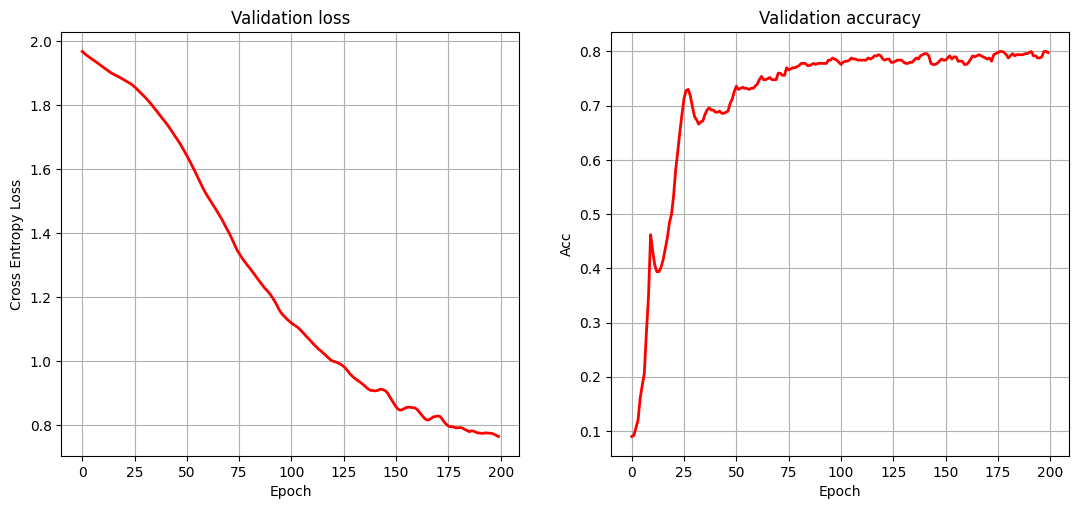

In [ ]:
visualize_validation_performance(val_acc_list, val_loss_list)

####Visulaize Learned Represenatation

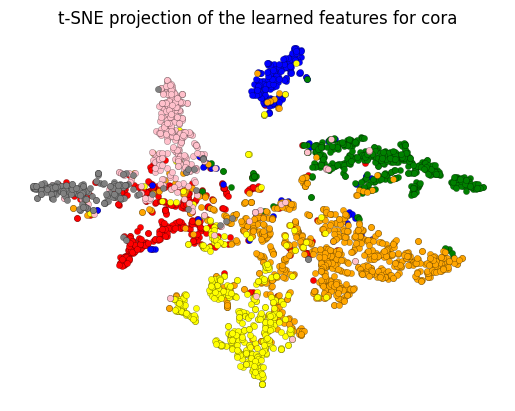

In [ ]:
visualize_learnedFeature_tSNE(labels, out_features, dataset)